In [2]:
import os
from torch.utils.data import Dataset
from PIL import Image
import json
import numpy as np
import torch
from torch.nn import functional as F, Module
import cv2
import csv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import albumentations as A
import torchmetrics
import torchvision
import e2cnn
import e2cnn.gspaces as gspaces
import e2cnn.nn as enn

/home/jliem/myenv/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### **SETUP**

Please run setup.sh (or ls > train_data.csv in cell train folder, same for val and test) prior to working with dataloader to ensure data is downloaded and data manifests are generated. The follow cell attempts to load the datamanifests for the custom loader to index over later.

In [ ]:
# directories for data
#cwd = os.path.join('home', 'jliem', 'CS1051', 'DeepLearning_Project')
dataDir = os.path.join(os.getcwd(), 'data', 'ocelot2023_v1.0.1')
annDir = os.path.join(dataDir, 'annotations')
imgDir = os.path.join(dataDir, 'images')

# Set of manifest files for indexing data
trainDataManifest = os.path.join(dataDir, 'train_data.csv')
valDataManifest = os.path.join(dataDir, 'val_data.csv')
testDataManifest = os.path.join(dataDir, 'test_data.csv')

Generates cell masks from the cell annotations (set of coordinates + some circle boundary) in the annotations directory. Cell annotations are originally only coordinates, and we can't perform segmentation on just a coordinate alone. Cell masks are saved in the same level as the cell annotations, but in a subdirectory called cell_masks.

In [199]:
def generate_cell_masks(annDir, partitions = ['train', 'val', 'test'], radius = 30):
    '''
    Generates cell masks from the cell annotations (set of coordinates + some radius) in the annotations directory.
    Cell masks are saved in the same directory as the cell annotations, but in a subdirectory called cell_masks.
    '''
    for partition in partitions:
        annCellDir = os.path.join(annDir, partition, 'cell')
        cellAnnFiles = os.listdir(annCellDir)
        for cellAnnFile in cellAnnFiles:

            # read in the csv
            cellAnnPath = os.path.join(annCellDir, cellAnnFile)

            # maybe be empty csv if no cells
            if os.path.getsize(cellAnnPath) > 0:
                cellAnn = pd.read_csv(cellAnnPath).to_numpy()
            else:
                cellAnn = np.empty((0, 0, 0))

            # generate the mask with circles of bounding box around each cell and color based on class
            mask = np.zeros((1024, 1024))
            for cell in cellAnn:
                x, y, lbl = cell

                # draw a circle around the cell 1 if it is background, 255 if it is cancer and add to mask
                if int(lbl) == 1:
                    color = 1
                elif int(lbl) == 2:
                    color = 2
                else:
                    color = 0
                cv2.circle(mask, (int(x), int(y)), radius, color, -1)
    
            # save the mask to annotations/partition/cell_masks as a .png
            maskPath = os.path.join(annDir, partition, 'cell_masks', cellAnnFile.replace('csv', 'png'))

            if not os.path.exists(os.path.dirname(maskPath)):
                os.makedirs(os.path.dirname(maskPath))

            cv2.imwrite(maskPath, mask)

generate_cell_masks(annDir, radius=30)

## **DATALOADER**

My dataloader that has been design specifically according to the ocelot dataset file structure (probably could be heavily improved for speed up and better placement of transforms). You can find a more current version of this loader under util/dataloader.py.

In [23]:
class OcelotDatasetLoaderV1(Dataset):
    def __init__(self, dataDir: str, dataManifest: str, trainMode = 'train', transforms=None, multiclass=True):
        '''
        Custom dataset loader for the Ocelot dataset. Trainmode should be one of ['train', 'val', 'test'],
        and always with corresponding dataManifest (trainManifest, valManifest, testManifest) or else bad indexing things will happen.
        This dataset should be treated as multiclass given background, cancer, and non-cancer classes, but it can be treated as binary if ignoring background
        in some scenarios.
        '''
        self.dataManifest = pd.read_csv(dataManifest)

        # Sanity check on right directory
        if not os.path.exists(dataDir):
            raise FileNotFoundError('dataDir does not exist')
        
        # Sanity check on existing dataManifest
        if not os.path.exists(dataManifest):
            raise FileNotFoundError('dataManifest does not exist')
        
        # Sanity check on valid trainMode
        if trainMode not in ['train', 'val', 'test']:
            raise ValueError('trainMode must be one of ["train", "val", "test"]')

        # args
        self.transforms = transforms
        self.dataDir = dataDir
        self.multiclass = multiclass
        self.trainMode = trainMode

        # metadata.json contains the coordinates of the cell images in the tissue images
        self.jsonObject = json.load(open(os.path.join(dataDir, 'metadata.json')))

        # convert manifest to list of file names and shuffle in case weird ordering of images
        self.dataManifest = list(pd.read_csv(dataManifest, header=None).loc[:,0])
        self.dataManifest = np.random.permutation(self.dataManifest)
        print(f'Found {len(self.dataManifest)} images for {trainMode} mode...')

        # set up paths to images and annotations
        self.tissImgAbsPath = os.path.join(self.dataDir, 'images', self.trainMode, 'tissue')
        self.cellImgAbsPath = os.path.join(self.dataDir, 'images', self.trainMode, 'cell')
        self.tissAnnAbsPath = os.path.join(self.dataDir, 'annotations', self.trainMode, 'tissue')
        self.cellAnnAbsPath = os.path.join(self.dataDir, 'annotations', self.trainMode, 'cell_masks')

    def __len__(self):
        return len(self.dataManifest)
    
    def __getitem__(self, idx):

        # uses the manifest to get a sample pair
        image_name = self.dataManifest[idx]

        tissImg = cv2.imread(os.path.join(self.tissImgAbsPath, image_name))
        cellImg = cv2.imread(os.path.join(self.cellImgAbsPath, image_name))
        tissAnn = cv2.imread(os.path.join(self.tissAnnAbsPath, image_name.replace('.jpg','.png')), 0)
        cellAnn = cv2.imread(os.path.join(self.cellAnnAbsPath, image_name.replace('.jpg','.png')), 0)

        # apply transforms to images
        if self.transforms:
            tsampleTissue = self.transforms(image=tissImg, mask=tissAnn)
            tsampleCell = self.transforms(image=cellImg, mask=cellAnn)
            tissImg = tsampleTissue['image']
            cellImg = tsampleCell['image']
            tissMask = tsampleTissue['mask']
            cellMask = tsampleCell['mask']
        
        return tissImg, cellImg, tissMask, cellMask

trainData = OcelotDatasetLoaderV1(dataDir=dataDir, dataManifest=trainDataManifest, trainMode='train', multiclass=True)

Found 400 images for train mode...


## **DATA VIZ**

The following cell  cell and tissue pair with their overlayed annotations + the cell mask I just generated in the previous cell.

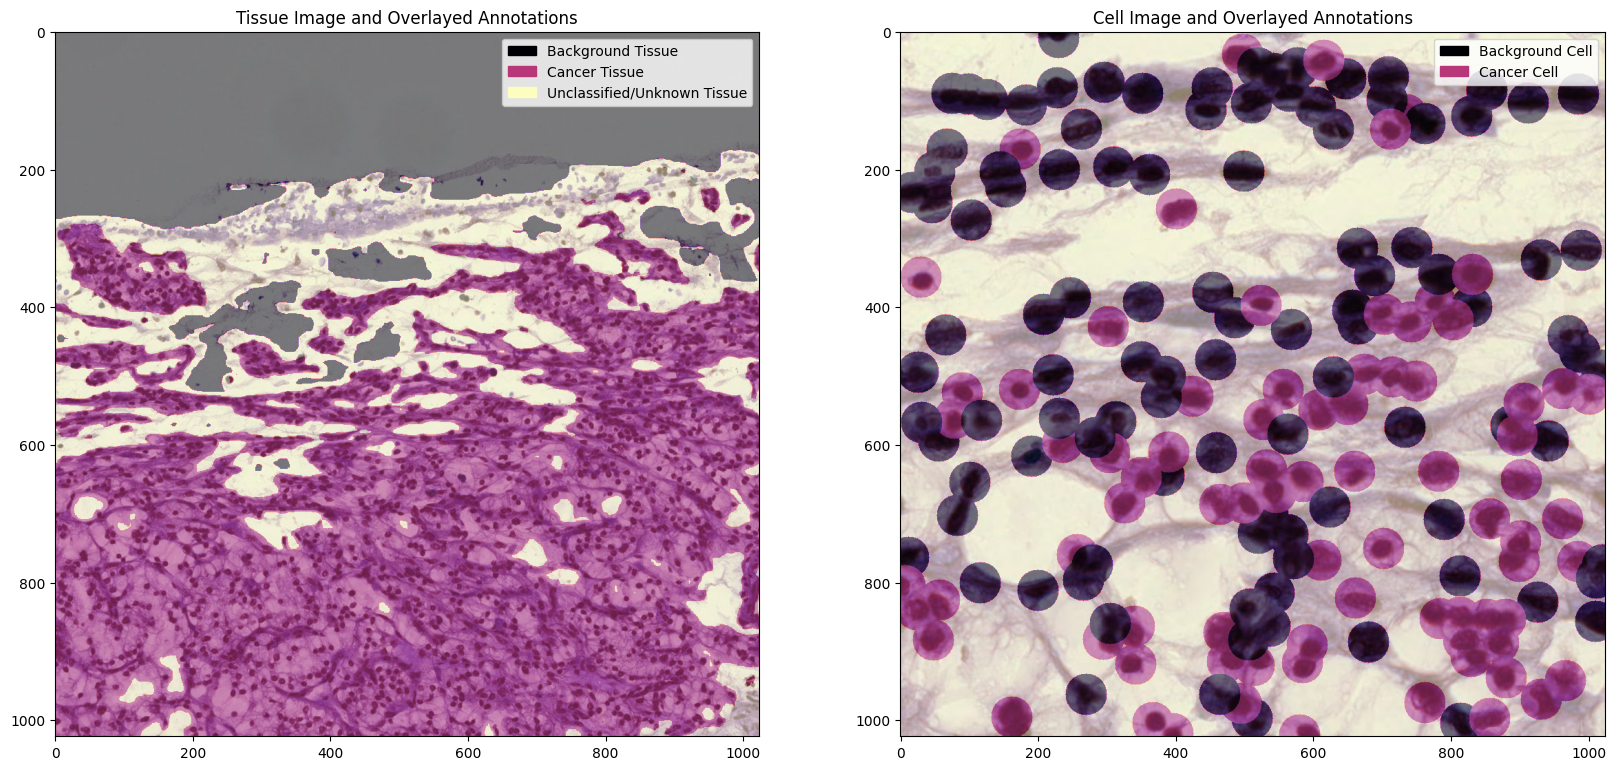

In [8]:
tissImg, cellImg, tissAnn, cellAnn = trainData[0]

# Shift pixel value for visualization
tissAnn = np.where(tissAnn == 2, 128, tissAnn) # 2 is cancer
tissAnn = np.where(tissAnn == 1, 0, tissAnn) # 1is background
# 255 is unknown/unspecified
cmap = plt.cm.magma
fig, ax = plt.subplots(1, 2, figsize=(20, 20))

# Plot the tissue image with overlayed annotations
im = ax[0].imshow(tissImg)
ax[0].imshow(tissAnn, alpha=0.5, cmap=cmap)
ax[0].set_title('Tissue Image and Overlayed Annotations')

background_patch = mpatches.Patch(color=cmap(0), label='Background Tissue')
cancer_patch = mpatches.Patch(color=cmap(128), label='Cancer Tissue')
unknown_patch = mpatches.Patch(color=cmap(255), label='Unclassified/Unknown Tissue')

ax[0].legend(handles=[background_patch, cancer_patch, unknown_patch], loc='upper right')

# Plot the cell image with overlayed annotations
cellAnn = np.where(cellAnn == 2, 128, cellAnn) # 2 is cancer
cellAnn = np.where(cellAnn == 0, 255, cellAnn) # 0 is unknown/unspecified
cellAnn = np.where(cellAnn == 1, 0, cellAnn) # 1is background

ax[1].imshow(cellImg)
ax[1].imshow(cellAnn, alpha=0.5, cmap=cmap)
ax[1].set_title('Cell Image and Overlayed Annotations')

background_cell = mpatches.Patch(color=cmap(0), label='Background Cell')
cancer_cell = mpatches.Patch(color=cmap(128), label='Cancer Cell')
ax[1].legend(handles=[background_cell, cancer_cell], loc='upper right')
plt.show()

## **NON-EQUIVARIANT CELL-SEGMENTATION**

The following series of cells is just a sanity check for the work in progress I did on the actual trainNonEquivariantCell.py and trainEquivariantCell.py training scripts. The follow are not meant to be treated as legitimate results as I resize to 64x64 on the images, just to check that it works correctly.

In [30]:
from monai.losses import DiceCELoss, DiceLoss, MaskedDiceLoss
from monai.metrics import MeanIoU
from monai.networks.utils import one_hot
from albumentations.pytorch import ToTensorV2
import albumentations as A
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
import torchmetrics
import torch
import os
import sys
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import numpy as np

path = os.getcwd()
par_path = os.path.abspath(os.pardir)
sys.path.append(par_path)

from model.unet import UnetVariant
from model.equivariantUnet import EqUnetVariant
from util.dataloader import OcelotDatasetLoaderV1

dataDir = os.path.join(os.getcwd(), 'data', 'ocelot2023_v1.0.1')
annDir = os.path.join(dataDir, 'annotations')
imgDir = os.path.join(dataDir, 'images')

# Set of manifest files for indexing data
trainDataManifest = os.path.join(dataDir, 'train_data.csv')
valDataManifest = os.path.join(dataDir, 'val_data.csv')
testDataManifest = os.path.join(dataDir, 'test_data.csv')

Just checking that I can correctly pass input to the model and selecting for a number of in_channels such that the number of parameters between equivariant and non equivariant models is relatively equal.

In [2]:
out_channels = 3
model = UnetVariant(img_channels=3, out_channels=out_channels, in_channels=64)
x = torch.randn(1, 3, 256, 256)
y = model(x)

num_params = sum(p.numel() for p in UnetVariant.parameters(model))
print(num_params)

out_channels = 3
model = EqUnetVariant(img_channels=3, out_channels=out_channels, in_channels=110)
x = torch.randn(1, 3, 256, 256)
y = model(x)

num_params = sum(p.numel() for p in EqUnetVariant.parameters(model))
print(num_params)

15670737
15434570


DataLoader with transforms. Transforms will NOT be applied to equivariant model later on... These are also only a small subset of transforms that I used in training (I played around with pixel, noise and color quite a bit too to simulate some weirdness in sample staining with H&E of WSIs).

In [3]:
# we only apply augmentations for non-equivariant
trainTransforms = A.Compose([A.ElasticTransform(p=0.2),
                             A.HorizontalFlip(p=0.5),
                             A.RandomRotate90(p=0.5),
                             A.Resize(64,64),
                             A.Normalize(mean = 0.0, std=1, always_apply=True),
                             ToTensorV2()
                             ])
valTestTransforms = A.Compose([A.Normalize(mean = 0.0, std=1, always_apply=True),
                               A.Resize(64,64),
                               ToTensorV2()])   

trainData = OcelotDatasetLoaderV1(dataDir=dataDir, dataManifest=trainDataManifest, transforms=trainTransforms, trainMode='train', multiclass=True)
valData = OcelotDatasetLoaderV1(dataDir=dataDir, dataManifest=valDataManifest, transforms=valTestTransforms, trainMode='val', multiclass=True)

batch_size = 1
num_workers = 3

trainLoader = DataLoader(trainData, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valLoader = DataLoader(valData, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Found 400 images for train mode...
Found 137 images for val mode...


Hyperparameters, model, loss, optimizer...

In [4]:
lr = 0.001
n_epochs = 10
out_channels = 3
img_channels = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optim = Adam(model.parameters(), lr=lr)
loss = DiceCELoss(sigmoid=True) if out_channels == 1 else DiceCELoss(softmax=True, to_onehot_y=True)
model = UnetVariant(img_channels=img_channels, out_channels=out_channels, in_channels=64).to(device)
print(f"Using {device}")

Using cuda


**DONT ACTUALLY TRAIN THE FOLLOWING IN THIS NOTEBOOK. SEE trainEquivariant.py AND trainNonEquivariant.py INSTEAD! THIS IS JUST TO TEST FUNCTIONALITY!**

In [ ]:
for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    for batch in tqdm(trainLoader):
        tissImg, cellImg, tissMask, cellMask = batch
        cellImg = cellImg.to(device)
        cellMask = cellMask.to(device).long() 

        optim.zero_grad()
        pred = model(cellImg) 

        train_loss = loss(pred, cellMask.unsqueeze(1))
        train_loss.backward()
        optim.step()

        train_loss += train_loss.item()

    train_loss /= len(trainLoader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(valLoader):
            tissImg, cellImg, tissMask, cellMask = batch
            cellImg = cellImg.to(device)
            cellMask = cellMask.to(device).long()

            pred = model(cellImg)
            val_loss = loss(pred, cellMask.unsqueeze(1)) 
            val_loss += val_loss.item()

    val_loss /= len(valLoader)
    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


100%|██████████| 137/137 [00:10<00:00, 12.88it/s]


Epoch 1/10, Train Loss: 0.0091, Val Loss: 0.0274


100%|██████████| 137/137 [00:10<00:00, 12.67it/s]


Epoch 2/10, Train Loss: 0.0098, Val Loss: 0.0274


100%|██████████| 137/137 [00:10<00:00, 12.49it/s]


Epoch 3/10, Train Loss: 0.0103, Val Loss: 0.0274


100%|██████████| 137/137 [00:10<00:00, 12.65it/s]


Epoch 4/10, Train Loss: 0.0096, Val Loss: 0.0274


100%|██████████| 137/137 [00:10<00:00, 12.89it/s]


Epoch 5/10, Train Loss: 0.0100, Val Loss: 0.0274


100%|██████████| 137/137 [00:11<00:00, 12.24it/s]


Epoch 6/10, Train Loss: 0.0097, Val Loss: 0.0274


100%|██████████| 137/137 [00:11<00:00, 12.36it/s]


Epoch 7/10, Train Loss: 0.0090, Val Loss: 0.0274


100%|██████████| 137/137 [00:10<00:00, 13.04it/s]


Epoch 8/10, Train Loss: 0.0101, Val Loss: 0.0274


100%|██████████| 137/137 [00:11<00:00, 11.87it/s]


Epoch 9/10, Train Loss: 0.0093, Val Loss: 0.0274


 35%|███▌      | 140/400 [00:24<00:39,  6.64it/s]

## **EQUIVARIANT CELL-SEGMENTATION**

Hyperparameters, model, loss, optimizer...

In [ ]:
lr = 0.001
n_epochs = 10
out_channels = 3
img_channels = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optim = Adam(model.parameters(), lr=lr)
loss = DiceCELoss(sigmoid=True) if out_channels == 1 else DiceCELoss(softmax=True, to_onehot_y=True)
model = EqUnetVariant(img_channels=img_channels, out_channels=out_channels, in_channels=64).to(device)
print(f"Using {device}")

**DONT ACTUALLY TRAIN THE FOLLOWING IN THIS NOTEBOOK. SEE trainEquivariant.py AND trainNonEquivariant.py INSTEAD! THIS IS JUST TO TEST FUNCTIONALITY!**

In [ ]:
for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    for batch in tqdm(trainLoader):
        tissImg, cellImg, tissMask, cellMask = batch
        cellImg = cellImg.to(device)
        cellMask = cellMask.to(device).long()  # Convert mask to class indices

        optim.zero_grad()
        pred = model(cellImg)  # Output shape: (B, 3, H, W)

        train_loss = loss(pred, cellMask.unsqueeze(1))  # Expecting cellMask to be (B, H, W)
        train_loss.backward()
        optim.step()

        train_loss += train_loss.item()

    train_loss /= len(trainLoader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(valLoader):
            tissImg, cellImg, tissMask, cellMask = batch
            cellImg = cellImg.to(device)
            cellMask = cellMask.to(device).long()

            pred = model(cellImg)
            val_loss = loss(pred, cellMask.unsqueeze(1))  # Ensure no mismatch
            val_loss += val_loss.item()

    val_loss /= len(valLoader)
    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


## **VISUALIZATIONS FOR MODELS**

The following performs some score calculations on the final trained models. Feel free to swap in any path of your choosing from the output directory so long as it corresponds with the right model and set of weights. I calculate Dice Score, MIOU (broken), and DiceCELoss. I also save some stuff for plotting later on predictions.

In [37]:
################################# MODEL 1 ####################################################################
# Load model 1 (Equivariant model)
model_path1 = '/home/jliem/CS1051/DeepLearning_Project/output/lr0.0001/equiv1024equalparamnoaug/model.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
equivariant_model = EqUnetVariant(img_channels=3, out_channels=3, in_channels=110)
equivariant_model.load_state_dict(torch.load(model_path1), strict=False)
equivariant_model.to(device)

################################# MODEL 2 ####################################################################
# Load model 2 (Classic model) output/lr0.0001/equiv1024equalparamnoaug
model_path2 = '/home/jliem/CS1051/DeepLearning_Project/output/lr0.0001/non_equiv1024equalparamuberlong/model.pth'

classic_model = UnetVariant(img_channels=3, out_channels=3, in_channels=64)
classic_model.load_state_dict(torch.load(model_path2), strict=False)
classic_model.to(device)
equivariant_model.eval()
classic_model.eval()

# Dice and loss metric setup
eqDice_metric = torchmetrics.Dice(average='macro', multiclass=True, num_classes=3).to(device)
classicDice_metric = torchmetrics.Dice(average='macro', multiclass=True, num_classes=3).to(device)
eqloss = DiceCELoss(softmax=True, to_onehot_y=True).to(device)
classicloss = DiceCELoss(softmax=True, to_onehot_y=True).to(device)
eqMIOU = MeanIoU(reduction='mean', include_background=False)
classicMIOU = MeanIoU(reduction='mean', include_background=False)

eqPredictions = []
classicPredictions = []
images = []
ground_truth = []
eqLosses = []
classicLosses = []
rawEqLogits = []
rawClassicLogits = []

# Data transforms for test set
valTestTransforms = A.Compose([A.Normalize(mean=0.0, std=1, always_apply=True), ToTensorV2()])

# Load the test dataset
testData = OcelotDatasetLoaderV1(dataDir=dataDir, dataManifest=testDataManifest, transforms=valTestTransforms, trainMode='test', multiclass=True)
testLoader = DataLoader(testData, batch_size=1, shuffle=False, num_workers=3)

# Time to run inference :)
with torch.no_grad():
    for batch in tqdm(testLoader):
        tissImg, cellImg, tissMask, cellMask = batch
        cellImg = cellImg.to(device)
        cellMask = cellMask.to(device).long()
        cellMask = cellMask.unsqueeze(1)

        # Get predictions from equivariant model
        eq_pred = equivariant_model(cellImg)
        eq_loss = eqloss(eq_pred, cellMask)
        eqDice_metric(eq_pred, cellMask)
        eqMIOU(eq_pred.argmax(dim=1), cellMask.squeeze(1))
        rawEqLogits.append(eq_pred)
        eqPredictions.append(eq_pred.argmax(dim=1).cpu().numpy())
        eqLosses.append(eq_loss.item())

        # Get predictions from classic
        classic_pred = classic_model(cellImg)
        classic_loss = classicloss(classic_pred, cellMask)
        classicDice_metric(classic_pred, cellMask)
        classicMIOU(classic_pred.argmax(dim=1), cellMask.squeeze(1))
        rawClassicLogits.append(classic_pred)
        classicPredictions.append(classic_pred.argmax(dim=1).cpu().numpy())
        classicLosses.append(classic_loss.item())

        # Store images and ground truth for visualization
        images.append(cellImg.cpu().numpy())
        ground_truth.append(cellMask.cpu().numpy())

    # Compute scores on both models
    eq_dice_score = eqDice_metric.compute()
    classic_dice_score = classicDice_metric.compute()
    eqMIOU_score = eqMIOU.aggregate().item()
    classicMIOU_score = classicMIOU.aggregate().item()

    print(f'Equivariant Model Dice Score: {eq_dice_score}')
    print(f'Classic Model Dice Score: {classic_dice_score}')
    print(f'Equivariant Model MIOU Score: {eqMIOU_score}') #TODO: NEEDS FIX FOR DIVISION BY ZERO. NOT TO BE TRUSTED FOR NOW

    # Compute average loss for both models
    eq_loss_val = sum(eqLosses) / len(eqLosses)
    classic_loss_val = sum(classicLosses) / len(classicLosses)

    print(f'Equivariant Model Loss: {eq_loss_val}')
    print(f'Classic Model Loss: {classic_loss_val}')
    print(f'Equivariant Model MIOU Score: {classicMIOU_score}') #TODO: NEEDS FIX FOR DIVISION BY ZERO. NOT TO BE TRUSTED FOR NOW

    eqPredictions = np.concatenate(eqPredictions)
    classicPredictions = np.concatenate(classicPredictions)
    ground_truth = np.concatenate(ground_truth)

/tmp/ipykernel_346396/1079453474.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  equivariant_model.load_state_dict(torch.load(model_path1), strict=False)
/tmp/ipykernel_

Found 126 images for test mode...


100%|██████████| 126/126 [00:16<00:00,  7.71it/s]


Equivariant Model Dice Score: 0.6273064613342285
Classic Model Dice Score: 0.6840800642967224
Equivariant Model MIOU Score: 2.1368279457092285
Equivariant Model Loss: 1.1681814392407734
Classic Model Loss: 2.2941786273131295
Equivariant Model MIOU Score: inf


Plot some predictions on their images (overlayed) for equivariant, nonequivariant, and ground truth

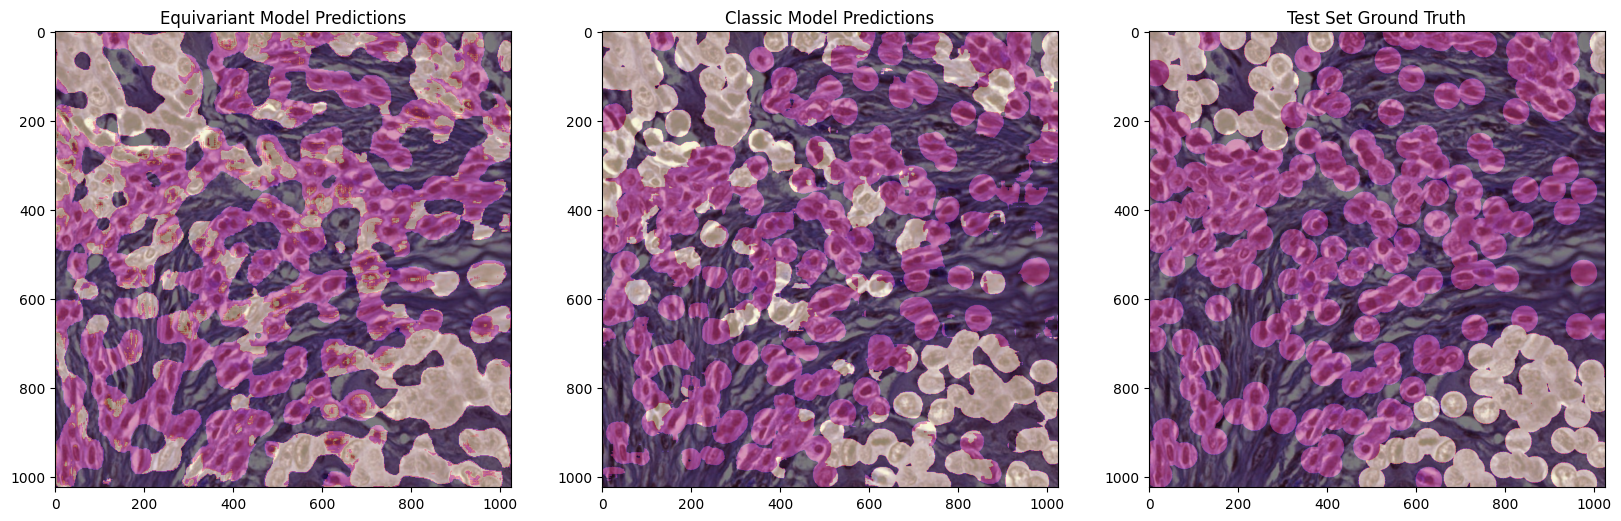

In [25]:
img_idx = 18 #CAN CHANGE
fig, ax = plt.subplots(1, 3, figsize=(20, 20))

# Plot the predictions and ground truth overlayed
images_rgb = np.transpose(images[img_idx].squeeze(), (1, 2, 0))
ax[0].imshow(images_rgb)
ax[0].imshow(eqPredictions[img_idx], cmap='magma', alpha=0.5)
ax[0].set_title('Equivariant Model Predictions')

# Plot the predictions for the classic model
ax[1].imshow(images_rgb)
ax[1].imshow(classicPredictions[img_idx], cmap='magma', alpha=0.5)
ax[1].set_title('Classic Model Predictions')

# Plot the ground truth overlayed
ground_truth_img = ground_truth[img_idx].squeeze()
ax[2].imshow(images_rgb)
ax[2].imshow(ground_truth_img, cmap='magma', alpha=0.5)
ax[2].set_title('Test Set Ground Truth')
plt.show()

For those corresponding images, also generate the class-wise probability map to understand what the model is doing a little bit better. 

Text(0.5, 1.0, 'Test Set Ground Truth')

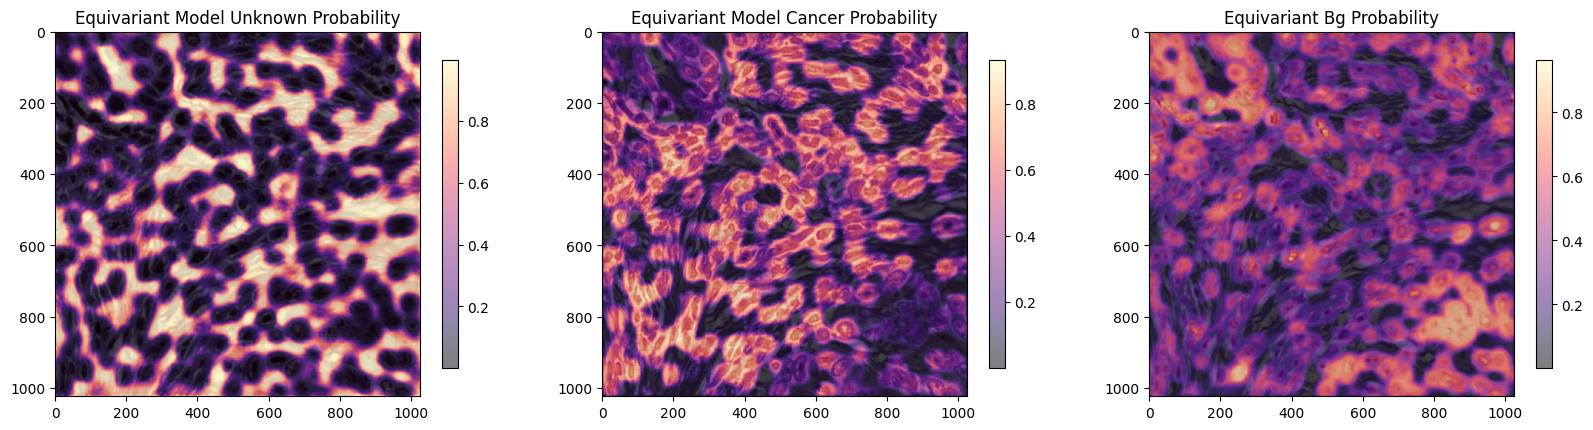

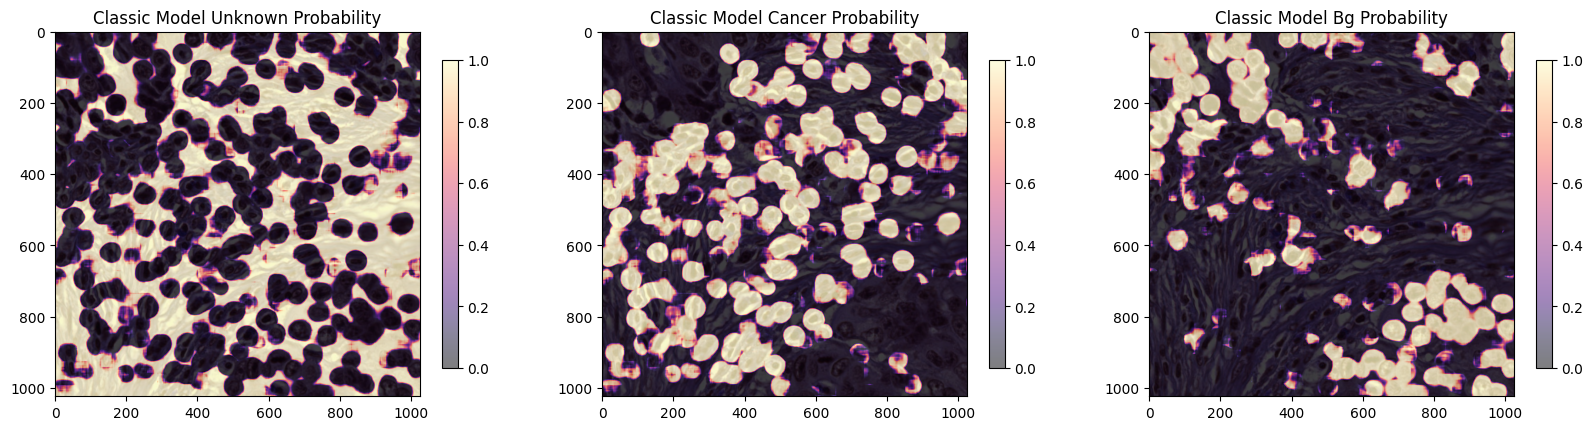

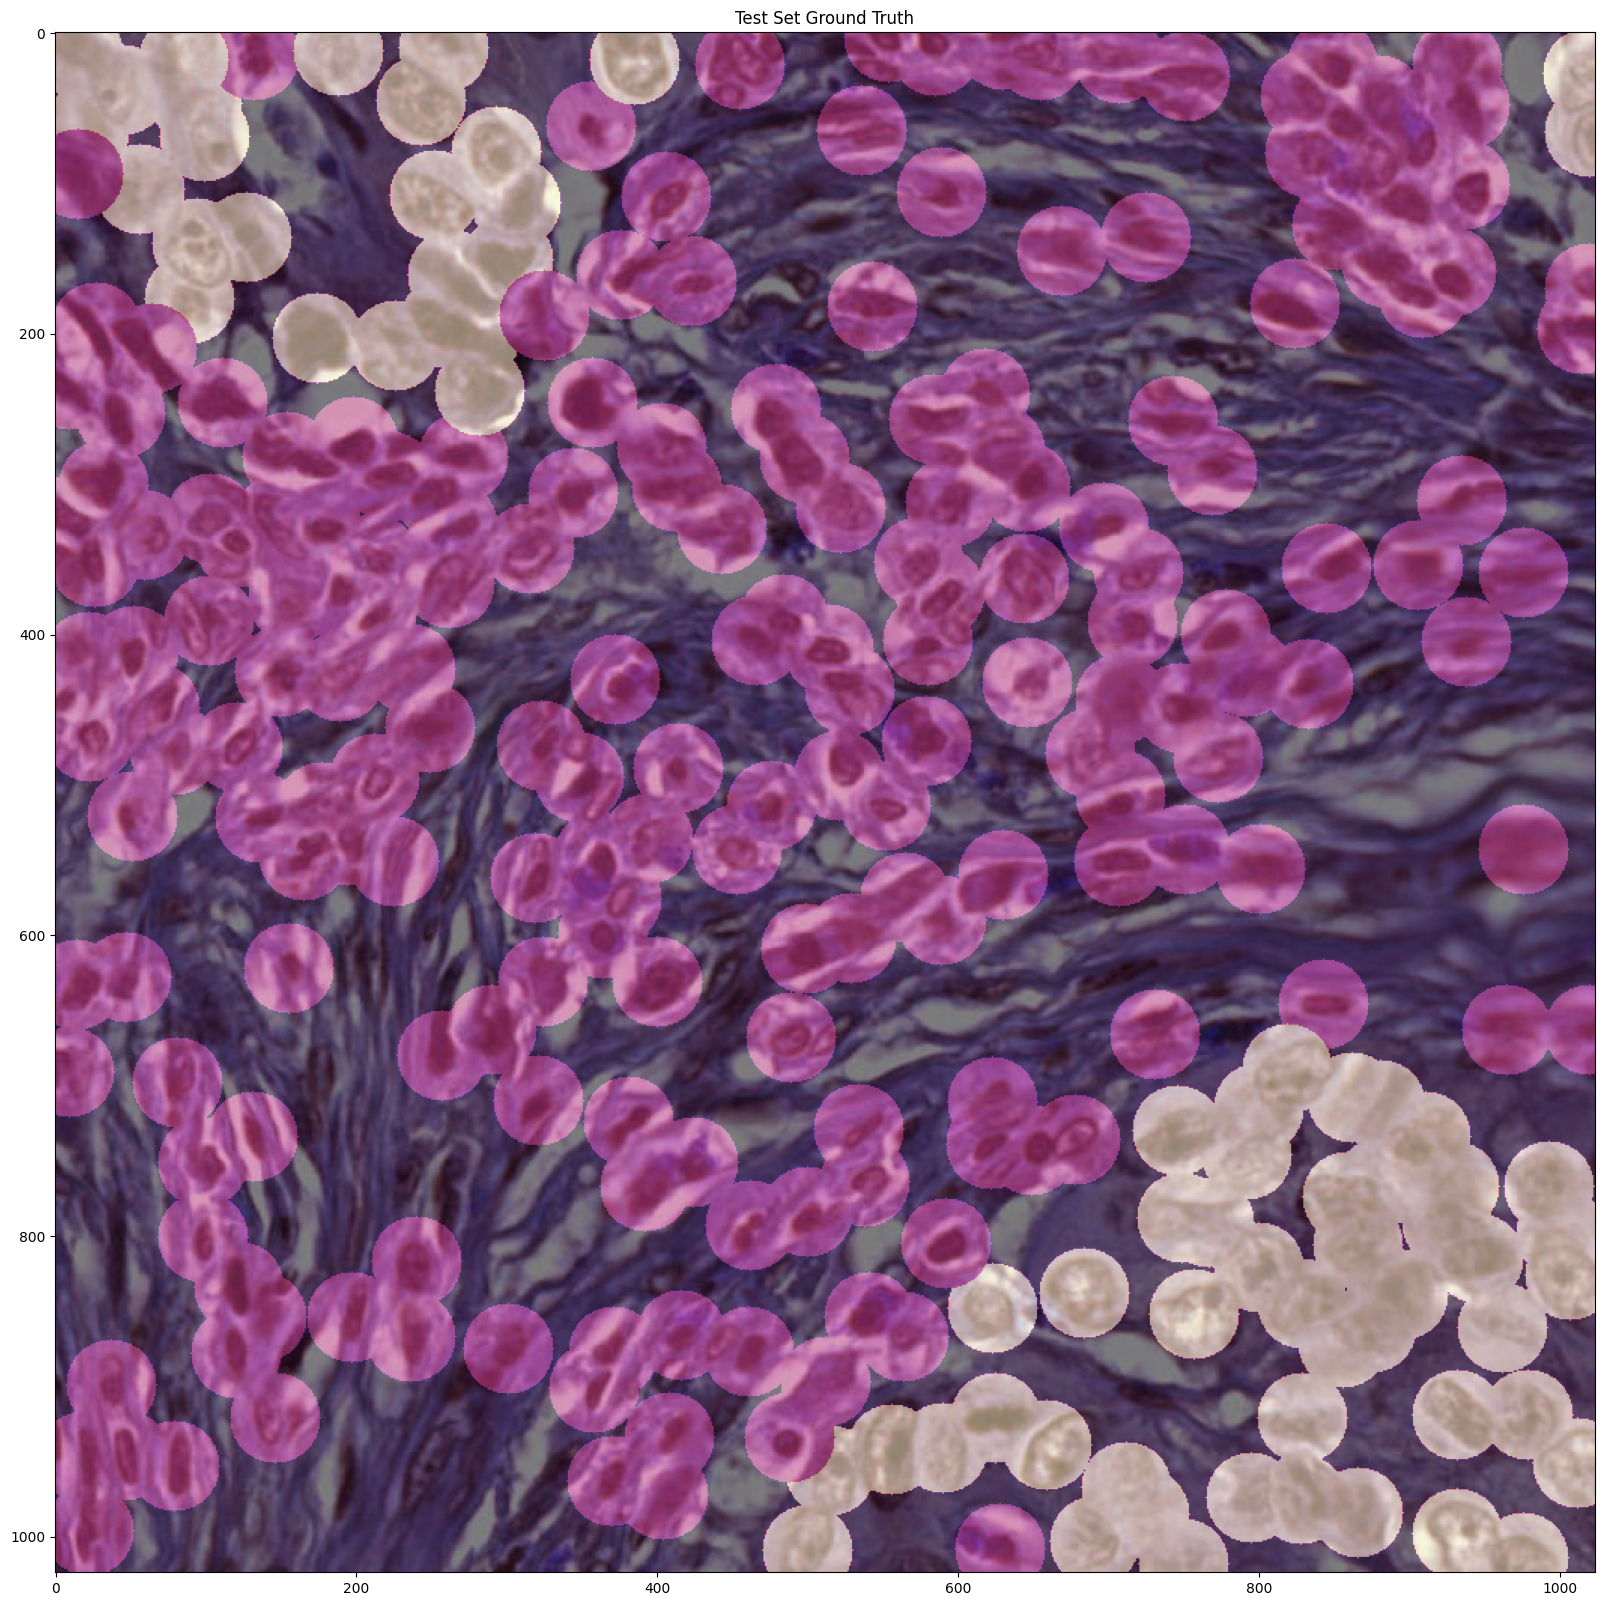

In [26]:
# plot probabilities for equivariant model
eq_logits = rawEqLogits[img_idx].squeeze().detach().cpu().numpy()
eq_probs = F.softmax(torch.tensor(eq_logits), dim=0).numpy()

fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(images[img_idx].squeeze().transpose(1, 2, 0))
ax[0].imshow(eq_probs[0], cmap='magma', alpha=0.5)
cbar = plt.colorbar(ax[0].imshow(eq_probs[0], cmap='magma', alpha=0.5), ax=ax[0], shrink=0.2)
ax[0].set_title('Equivariant Model Unknown Probability')

ax[1].imshow(images[img_idx].squeeze().transpose(1, 2, 0))
ax[1].imshow(eq_probs[1], cmap='magma', alpha=0.5)
cbar = plt.colorbar(ax[1].imshow(eq_probs[1], cmap='magma', alpha=0.5), ax=ax[1], shrink=0.2)
ax[1].set_title('Equivariant Model Cancer Probability')

ax[2].imshow(images[img_idx].squeeze().transpose(1, 2, 0))
ax[2].imshow(eq_probs[2], cmap='magma', alpha=0.5)
cbar = plt.colorbar(ax[2].imshow(eq_probs[2], cmap='magma', alpha=0.5), ax=ax[2], shrink=0.2)
ax[2].set_title('Equivariant Bg Probability')

# for classic model
classic_logits = rawClassicLogits[img_idx].squeeze().detach().cpu().numpy()
classic_probs = F.softmax(torch.tensor(classic_logits), dim=0).numpy()

fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(images[img_idx].squeeze().transpose(1, 2, 0))
ax[0].imshow(classic_probs[0], cmap='magma', alpha=0.5)
cbar = plt.colorbar(ax[0].imshow(classic_probs[0], cmap='magma', alpha=0.5), ax=ax[0], shrink=0.2)
ax[0].set_title('Classic Model Unknown Probability')

ax[1].imshow(images[img_idx].squeeze().transpose(1, 2, 0))
ax[1].imshow(classic_probs[1], cmap='magma', alpha=0.5)
cbar = plt.colorbar(ax[1].imshow(classic_probs[1], cmap='magma', alpha=0.5), ax=ax[1], shrink=0.2)
ax[1].set_title('Classic Model Cancer Probability')

ax[2].imshow(images[img_idx].squeeze().transpose(1, 2, 0))
ax[2].imshow(classic_probs[2], cmap='magma', alpha=0.5)
cbar = plt.colorbar(ax[2].imshow(classic_probs[2], cmap='magma', alpha=0.5), ax=ax[2], shrink=0.2)
ax[2].set_title('Classic Model Bg Probability')

# plot single ground truth image with overlay
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ground_truth_img = ground_truth[img_idx].squeeze()
ax.imshow(images[img_idx].squeeze().transpose(1, 2, 0))
ax.imshow(ground_truth_img, cmap='magma', alpha=0.5)
ax.set_title('Test Set Ground Truth')